In [3]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Theory

We know that the Schroedinger Equation is:

$$ i\hbar\partial_t\Psi = H\Psi $$

We know that the solution to this equation is a complex number.

$$ \Psi = Re^{iS/\hbar} = A + iB $$

Lets see how we can develop a numerical scheme - How about Euler to start?

Let 


Then we can write the SE as:

$$ \partial_t\Psi = i[D\nabla^2\Psi - \omega(x)]\Psi $$


$$ \partial_t\Psi = iL\Psi $$

We know that:

$$ \Psi(t+h) = e^{iLh} \Psi $$

the operator on Psi is unitary meaning if we take a negative time step we should be able to retrieve our original wavefunction.

Now if we use an eulerian step then:

$$ \Psi(t+h) = (1+iLh)\Psi (t) $$

Now; $ (1+iLh)(1-iLh) = 1+L^2h^2 > 1 $so the propagator is not unitary and hence Eulers method is unstable.

The alternative would be to use CN method:

$$ \Psi(t+h) - \Psi(t) = iLh(\Psi(t+h) +\Psi(t))/2 $$

$$ (1-iLh/2)\Psi(t+h) = (1+iLh/2)\Psi(t) $$

Therefore the operator is: $ (1+iLh/2)(1-iLh/2)^-1 $ which is unitary since changing h to -h means we get the complex conjugate of the above expression. which leads to $ 1+l^2h^2/1+h^2l^2 = 1 $. So we achieve stability in this schema.


An alternative method to these is known as Visscher Method, in this we start by saying:

$$ \Psi = A + iB $$

$$ \partial_tA + i\partial_tB = iLhA + i^2LhB $$

which leads to:

$$ \partial_tA = -LB $$

$$ \partial_tB = LA $$

So if you look at three time steps, you can essentially solve this synchronously:

$$ A^{n+1} - A^{n-1} = -2hL B^n $$

$$ B^{n+1} - B^{n-1} = 2hLA^n $$

Of course to do this you will need to initialize 2 time steps.



In [4]:
# Function definitions
def qm(lop,dif,omh):

    nx = 101
    Aold = np.zeros(nx)
    A = np.zeros(nx)
    Anew = np.zeros(nx)
    Bold = np.zeros(nx)
    B = np.zeros(nx)
    Bnew = np.zeros(nx)
    x = np.zeros(nx)
    pot = np.zeros(nx)
    qpot = np.zeros(nx)
    hc = np.zeros(nx)
    hw = np.zeros(nx)
    he = np.zeros(nx)
    jw= np.zeros(nx)
    je = np.zeros(nx)
    rho = np.zeros(nx)
    lop = lop
    main = []
    energy = []

    nout = 100

    dif =dif
    omh =omh
    hlen = np.sqrt(0.5*dif/omh)
    hvel = np.sqrt(0.5*dif*omh)

    sigma = hlen
    vel = hvel

    htim = 2*np.pi/omh
    sizex = 20*hlen

    sizet = 200*htim
    dx = sizex/float(nx-1)
    dt = 0.01/omh

    nt = sizet/dt

    if lop == 0:
        vamp = 0
    else:
        vamp = 1

    dtd = 1
    if dif != 0:
        dtd = 0.5*dx*dx/dif
    dta = 1
    if vel != 0:
        dta = dx/abs(vel)

    cfl = 0.5
    dt = cfl*min(dta,dtd)

    delta = dif*dt/(dx**2)
    alfa = vel*dt/dx
    omega = vamp*dt

    if(alfa > 1.0):
        print('dt too large, alfa')
    if(delta>1.0):
        print('dt too large, delta')
    if(omega>1.0):
        print('dt too large, omega')


    #potmax = 0.5*omh*omh*(0.25*sizex*sizex)
    if(lop>1):
        potmax=vamp

    j0 = (nx-1)/2
    for j in range(nx):
        x[j]= -0.5*sizex+dx*(float(j))
        xj   = x[j]
        rho[j]  = np.exp(-0.25*xj*xj/sigma/sigma)
        Aold[j] = rho[j]*np.cos(vel*xj)
        Bold[j] = rho[j]*np.sin(vel*xj)
        rhoA    = Aold[j]*Aold[j]
        rhoB    = Bold[j]*Bold[j]
        if(lop == 1):           
            pot[j] = vamp*0.5*omh*omh*xj*xj
        elif lop == 0:
            pot[j] = 0.0
        elif lop == 2:
            pot[j]=0.0                         
            j1 = 2
            j2 = j1 + 0.5
            if(x[j]>j1) and (x[j]<j2):
                pot[j]=vamp


    for j in range(nx):
        je[j] = int(j+1)
        if (je[j]>nx-1):
            je[j]= int(0)
        jw[j] = int(j-1)
        if(jw[j]<0):
            jw[j]= int(nx-1)
        omega = pot[j]*dt
        hc[j] =  delta+omega
        hw[j] = -delta/2.
        he[j] = -delta/2.

        hB    = hc[j]*Bold[j]+hw[j]*Bold[int(jw[j])]+he[j]*Bold[int(je[j])]
        A[j]  = Aold[j]+hB
        hA    = hc[j]*Aold[j]+hw[j]*Aold[int(jw[j])]+he[j]*Aold[int(je[j])]
        B[j]  = Bold[j]-hA

    nt = 1000
    for it in range(2,int(nt)):
        for j in range(nx): 
            hB = hc[j]*B[j]+hw[j]*B[int(jw[j])]+he[j]*B[int(je[j])]
            Anew[j] = Aold[j]+2.0*hB

        for j in range(nx):
            hA = hc[j]*A[j]+hw[j]*A[int(jw[j])]+he[j]*A[int(je[j])]
            Bnew[j] = Bold[j]-2.0*hA


        # c prepare new timestep
        for j in range(nx):
            Aold[j] = A[j] 
            Bold[j] = B[j] 
            A[j] = Anew[j]
            B[j]    = Bnew[j] 

            rho[j] = (A[j]*A[j]+B[j]*B[j])
        main.append((np.copy(A),np.copy(B),np.copy(rho)))
        # diagnostic
        if(np.mod(it,nout) ==1):
            tmass = 0.0
            ave   = 0.0
            var   = 0.0
            epot  = 0.0
            ekin  = 0.0
            for j in range(nx):
                rhoA = A[j]*A[j]
                rhoB = B[j]*B[j]
                if(rho[j] > 1.e-3):
                    qpot[j]= np.sqrt(rho[int(je[j])])-2.0*np.sqrt(rho[j])+np.sqrt(rho[int(jw[j])])
                    qpot[j]=-qpot[j]/(dx*dx*np.sqrt(rho[j]))
                else:
                    qpot[j]=0.0

                ue=np.arctan(B[int(je[j])]/A[int(je[j])])
                uw=np.arctan(B[int(jw[j])]/A[int(jw[j])])
                uvel=0.5*(ue-uw)/dx
                tmass  = tmass+ rho[j]*dx
                ave    = ave  + x[j]*rho[j]*dx
                var    = var  + x[j]*x[j]*rho[j]*dx

                dA   = 0.5*(A[int(je[j])]-A[int(jw[j])])/dx
                dB   = 0.5*(B[int(je[j])]-B[int(jw[j])])/dx
                ekin = ekin + 0.5*(dA*dA+dB*dB)*dx
                epot = epot + pot[j]*rho[j]*dx

            ave = ave/tmass
            rms = np.sqrt(var/tmass -ave*ave)
            energy.append((np.copy(ekin),np.copy(epot),np.copy(tmass)))
    return main,energy,x,pot

def feeder(i,j,k):
    
    main ,energy,x,pot = qm(i,j,k)
    main = np.array(main)
    energy = np.array(energy)

    tenerg = np.linspace(0,1,9)
    plt.figure()
    plt.plot(tenerg,energy[:,0],label ='kinetic')
    plt.plot(tenerg,energy[:,1],label = 'potential')
    plt.plot(tenerg,energy[:,1]+energy[:,0],label ='total')
    plt.title('Energy Conservation in QHO')
    plt.legend(loc = 'best')

    plt.figure()
    plt.plot(x,pot,label ='potential well',linestyle = '--')
    plt.plot(x,main[0,2,:],label = 'initial state')
    plt.plot(x,main[100,2,:],label = '100dt')
    plt.plot(x,main[500,2,:],label = '500dt')
    plt.plot(x,main[900,2,:],label = '900dt')
    plt.legend()
    plt.ylim([0,2])
    plt.xlim([-4,4])
    plt.title('rho evolution with dif ='+str(i) + 'omh =' +str(j))
    plt.xlabel('position')
    plt.ylabel(r'$\rho$')

# Harmonic Oscillator

omh = 1 and dif = 1

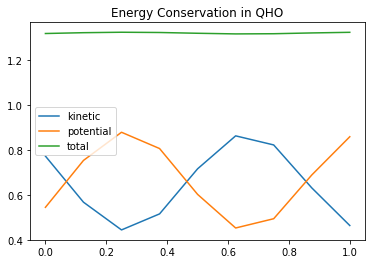

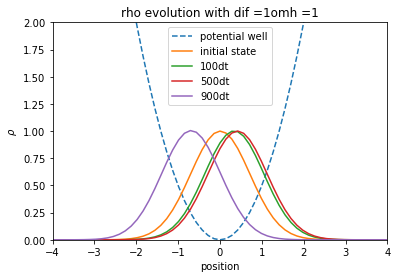

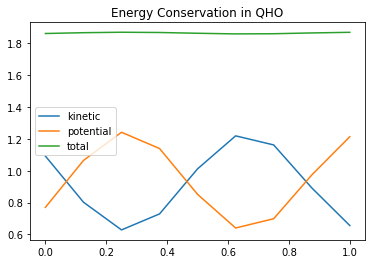

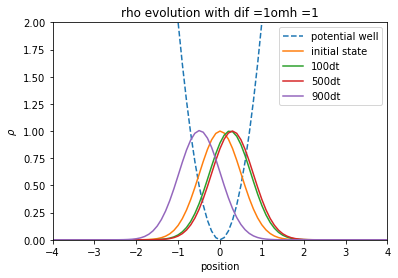

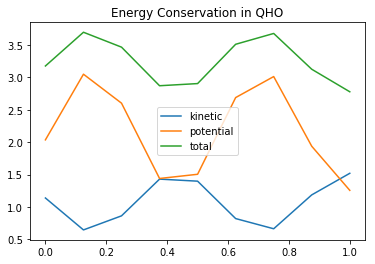

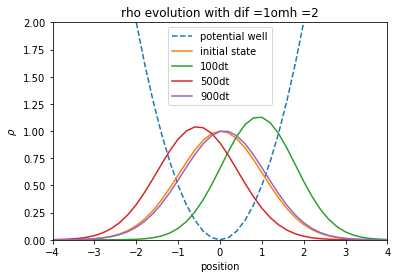

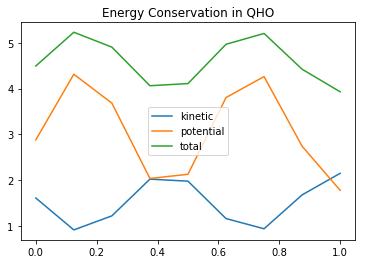

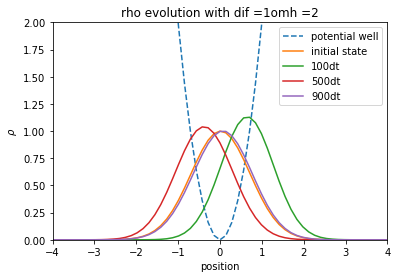

In [5]:
for i in range(1,3):
    for j in range(1,3):
        feeder(1,i,j)

In the figure above we can see the time evolution of $\rho$ in space

# Free particle

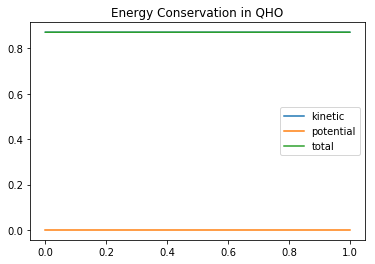

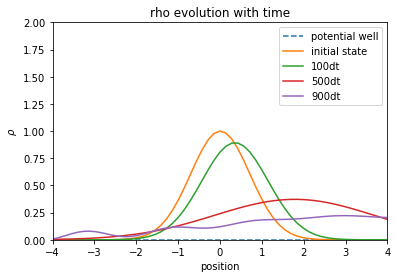

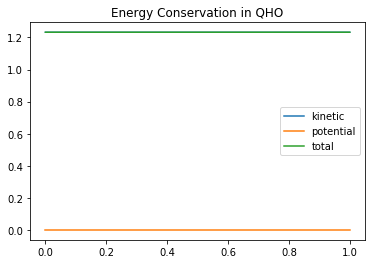

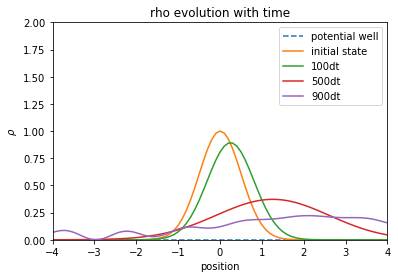

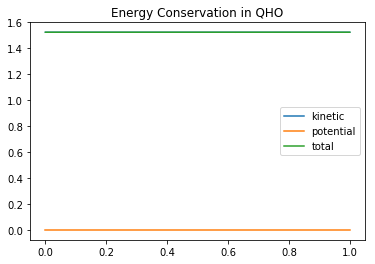

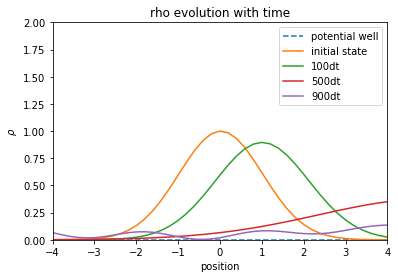

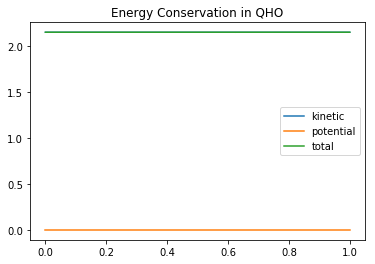

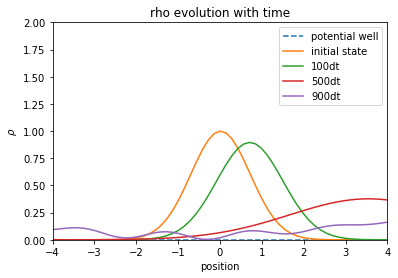

In [10]:
for i in range(1,3):
    for j in range(1,3):
        feeder(0,i,j)

# Finite well

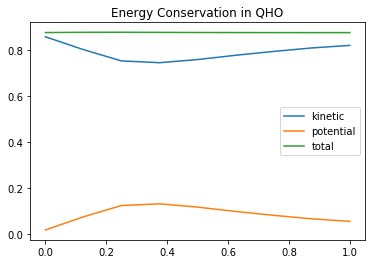

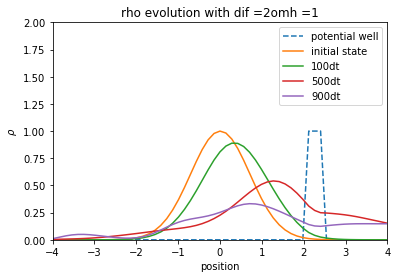

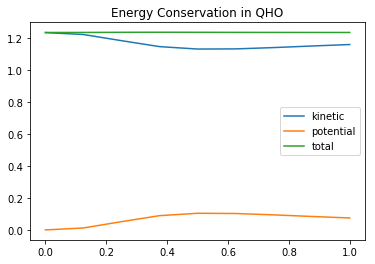

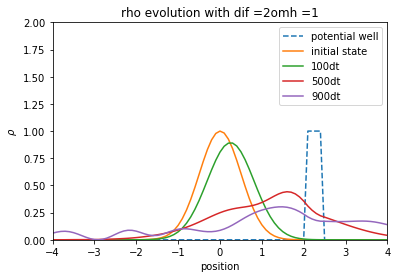

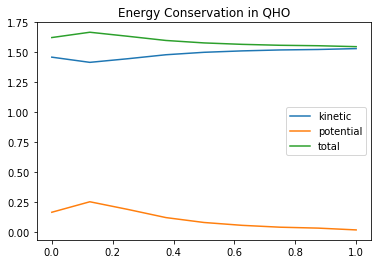

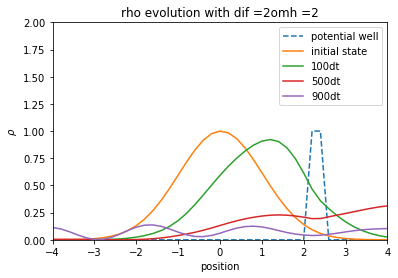

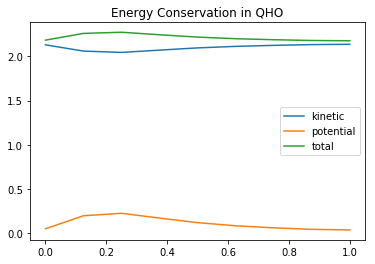

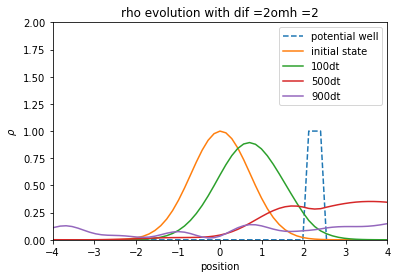

In [10]:
for i in range(1,3):
    for j in range(1,3):
        feeder(2,i,j)

# Finding the ground state

# Theory

One way to find the ground state is to use the conversion to imaginary time which casts our problem into the form:

$$ t \rightarrow i\tau $$

This means our SE becomes:

$$ \partial_t\Psi = (H/\hbar)\Psi  = D\nabla^2\Psi - \omega \Psi $$

Now the solution to this equation is:

$$ \Psi(x,\tau) = \sum_{n=0}^{\infty} c_n e^{-\omega_n\tau} \Psi_{n}(x) $$

As time evolves, the function decays and eventually, only 1 frequency will remain - the ground state!

$$ \Psi(x,\tau>1/\omega_1) = c_oe^{-\omega_o\tau} \Psi_o(x) $$

# Computing the Ground State

In [14]:
def gnd(lop):
    nx=101
    nm=4
    x = np.zeros(nx+2)
    fnew = np.zeros(nx+2)
    f = np.zeros(nx+2)
    pot = np.zeros(nx+2)
    fmom = np.zeros(nm+1)
    hmom = np.zeros(nm+1)
    Nsteps = 10000
    nout   = 200
    main = []
    ptracker = []
    ptracker2 = []
    mvar = []
    qp = []
    fstar = np.zeros(nx+2)
    qpot = np.zeros(nx+2)
    tt = []
    lop = lop
    sizex  = 10.0
    dx     = sizex/float(nx-1)
    dif    = 1.0
    vel    = 0.0
    vamp   = 1.0   
    cfl   = 0.10
    dtd   = 1.0
    if(dif !=0.0):
        dtd = dx*dx/dif
    dta   = 1.0
    if(vel != 0.0):
        dta = dx/vel
    dtc   = 1.0
    if(vamp !=0.0):
        dtc = 1.0/(vamp*sizex*sizex)

    dt    = cfl*min(min(dta,dtd),dtc)
    print(dt)
    alfa   = vel*dt/dx
    delta  = dif*dt/(dx*dx)
    
    wid = 1
    for j in range(1,nx+2): 
        pot[j] = 0
        x[j]   = dx*float(j-1-nx/2)
        xj     = x[j]/wid

        f[j]   = (1.0+0.5*xj)*np.exp(-0.5*xj*xj)
        if lop == 0:
            pot[j] = 2*0.5*vamp*x[j]*x[j]
        if lop == 1:
            xi = -3.
            xf = 3.
            if (x[j]<xi) or (x[j]>xf):
                pot[j] = 100
    coef = 0
    for j in range(1,nx+1): 
        coef = coef + dx*f[j]*f[j]
    for j in range(1,nx+1): 
        f[j]/np.sqrt(coef)
    
    for tim in range(1,Nsteps):
        time = (tim-1)*dt
        f[0]    = f[nx]
        f[nx+1] = f[1]
        for j in range(1,nx+1):
            a = delta+0.5*alfa
            b = delta-0.5*alfa
            c = 1.0-a-b-pot[j]*dt
            fnew[j] = a*f[j-1]+c*f[j]+b*f[j+1]

        for j in range(1,nx+1):
            f[j] = fnew[j]
        main.append(np.copy(f))
        if tim == 4000:
            f[0]    = f[nx]
            f[nx+1] = f[1]
            norm = 0
            for j in range(1,nx+1):
                fj = f[j]*f[j]
                norm = norm + fj*dx
            # normalize
            #new = f/norm
            for j in range(1,nx+1):
                a = delta+0.5*alfa
                b = delta-0.5*alfa
                c = -a-b-pot[j]*dt
                fstar[j] = a*f[j-1]+c*f[j]+b*f[j+1]
            eigv = 0
            for j in range(1,nx+1):
                fj = f[j]*fstar[j]
                eigv = eigv + fj*dx
            print(eigv)
            print(norm)
                
        if(np.mod(tim,nout) == 1):
            for m in range(nm+1):
                fmom[m] = 0.0
                hmom[m] = 0.0
            ptracker.append(np.copy(f[32]))
            for j in range(1,nx+1):
                if f[j] > 10**(-8):
                    qpot[j]= np.sqrt(f[j-1])-2.0*np.sqrt(f[j])+np.sqrt(f[j+1])
                    qpot[j]=-qpot[j]/(dx*dx*np.sqrt(f[j]))
                else:
                    qpot[j]=0.0

                fj = f[j]
                fmom[0] = fmom[0] + fj*dx
                fmom[1] = fmom[1]+ fj*x[j]*dx
                fmom[2] = fmom[2]+ fj*x[j]*x[j]*dx
                hmom[2] = hmom[2] + fj*fj*dx
                fmean = fmom[1]/fmom[0]
                fvar  = fmom[2]/fmom[0]-fmean*fmean
            mvar.append((np.copy(fmom[0]),np.copy(fmean),fvar))
            qp.append(np.copy(qpot))
            tt.append(time)
    return main,mvar,x,pot,tt,qp,ptracker

0.001


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:103: RuntimeWarning: invalid value encountered in sqrt


-5.94817843221e-07
0.000595190053478


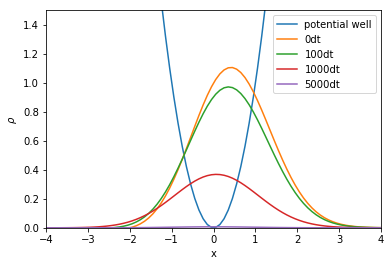

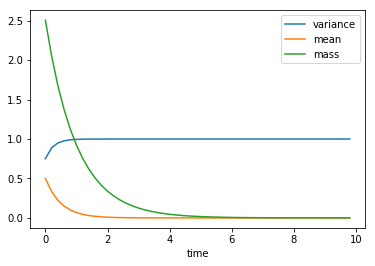

In [15]:
main,mvar,x,pot,tt,qp,ptracker = gnd(0)
main = np.array(main)
plt.figure()
plt.plot(x[1:-1],pot[1:-1],label = 'potential well')
plt.plot(x[1:-1],main[0,1:-1],label = '0dt')
plt.plot(x[1:-1],main[100,1:-1],label = '100dt')
plt.plot(x[1:-1],main[1000,1:-1],label = '1000dt')
plt.plot(x[1:-1],main[5000,1:-1],label = '5000dt')
plt.ylim([0,1.5])
plt.xlim([-4,4])
plt.ylabel(r'$\rho$')
plt.xlabel('x')
plt.legend()

mvar = np.array(mvar)
plt.figure()
plt.plot(tt,mvar[:,2],label = 'variance')
plt.plot(tt,mvar[:,1],label = 'mean')
plt.plot(tt,mvar[:,0],label = 'mass')
plt.legend()
plt.xlabel('time')




-0.999873307926 -1.90392793909


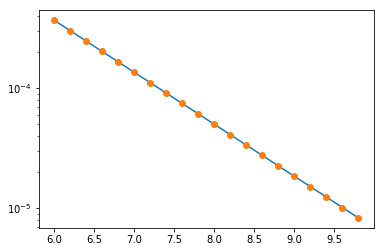

In [16]:
tt = np.array(tt)
ptracker = np.array(ptracker)
plt.semilogy(tt[30:],ptracker[30:])
a, b = np.polyfit(tt[30:],np.log(ptracker[30:]),1)
tt = np.array(tt)
plt.semilogy(tt[30:],np.exp(b)*np.exp(a*tt[30:]),'o')
print(a,b)
# tt = np.array(tt)
# np.polyfit(tt[20:], np.log(ptracker[20:]), 1)
#plt.plot(tt,np.exp(-7.63367532*10**(-1))*np.exp(-6.77356775e-04*tt))

In [18]:
print('The Energy of this Eigenstate is = %s' %-a)

The Energy of this Eigenstate is = 0.999873307926


0.001


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:103: RuntimeWarning: invalid value encountered in sqrt


-5.20144229078e-05
0.204015017453


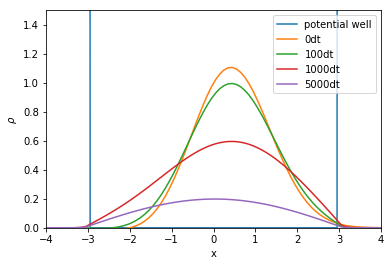

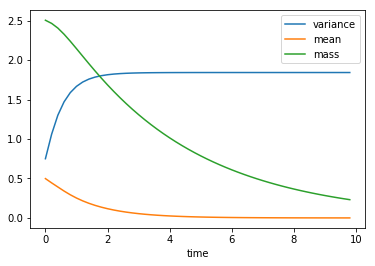

In [21]:
main,mvar,x,pot,tt,qp,ptracker = gnd(1)
main = np.array(main)
plt.figure()
plt.plot(x[1:-1],pot[1:-1],label = 'potential well')
plt.plot(x[1:-1],main[0,1:-1],label = '0dt')
plt.plot(x[1:-1],main[100,1:-1],label = '100dt')
plt.plot(x[1:-1],main[1000,1:-1],label = '1000dt')
plt.plot(x[1:-1],main[5000,1:-1],label = '5000dt')
plt.ylim([0,1.5])
plt.xlim([-4,4])
plt.ylabel(r'$\rho$')
plt.xlabel('x')
plt.legend()

mvar = np.array(mvar)
plt.figure()
plt.plot(tt,mvar[:,2],label = 'variance')
plt.plot(tt,mvar[:,1],label = 'mean')
plt.plot(tt,mvar[:,0],label = 'mass')
plt.legend()
plt.xlabel('time')


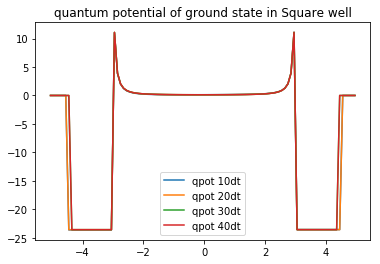

In [22]:
qp = np.array(qp)
plt.plot(x[1:-1],qp[10,1:-1],label = 'qpot 10dt')
plt.plot(x[1:-1],qp[20,1:-1],label = 'qpot 20dt')
plt.plot(x[1:-1],qp[30,1:-1],label = 'qpot 30dt')
plt.plot(x[1:-1],qp[40,1:-1],label = 'qpot 40dt')
plt.legend()
plt.title('quantum potential of ground state in Square well')

We can see here, the function takes on a strange shape in space, reflecting the notion that quantum potentiality can create decoherence

# In what follows I solve for the first excited state using some normalizations

In [23]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
def gnd(lop):
    nx=101
    nm=4
    x = np.zeros(nx+2)
    fnew = np.zeros(nx+2)
    f = np.zeros(nx+2)
    pot = np.zeros(nx+2)
    fmom = np.zeros(nm+1)
    hmom = np.zeros(nm+1)
    Nsteps = 15000
    nout   = 200
    main = []
    ptracker = []
    ptracker2 = []
    mvar = []
    qp = []
    fstar = np.zeros(nx+2)
    qpot = np.zeros(nx+2)
    tt = []
    lop = lop
    sizex  = 10.0
    dx     = sizex/float(nx-1)
    dif    = 1.0
    vel    = 0.0
    vamp   = 1.0   
    cfl   = 0.10
    dtd   = 1.0
    if(dif !=0.0):
        dtd = dx*dx/dif
    dta   = 1.0
    if(vel != 0.0):
        dta = dx/vel
    dtc   = 1.0
    if(vamp !=0.0):
        dtc = 1.0/(vamp*sizex*sizex)

    dt    = cfl*min(min(dta,dtd),dtc)

    alfa   = vel*dt/dx
    delta  = dif*dt/(dx*dx)
    
    wid = 1
    # define potential and function
    for j in range(1,nx+2): 
        pot[j] = 0
        x[j]   = dx*float(j-1-nx/2)
        xj     = x[j]/wid

        f[j]   = (1.0+0.5*xj)*np.exp(-0.5*xj*xj)
        if lop == 0:
            pot[j] = 2*0.5*vamp*x[j]*x[j]
        if lop == 1:
            xi = -3.
            xf = 3.
            if (x[j]<xi) or (x[j]>xf):
                pot[j] = 100
    print(dt,dx)
    # Normalizing
    coef = 0
    for j in range(1,nx+1): 
        coef = coef + dx*f[j]*f[j]
    for j in range(1,nx+1): 
        f[j] /= np.sqrt(coef)
    main.append(np.copy(f))
    for tim in range(1,Nsteps):
        time = (tim-1)*dt
        f[0]    = f[nx]
        f[nx+1] = f[1]
        for j in range(1,nx+1):
            a = delta+0.5*alfa
            b = delta-0.5*alfa
            c = 1.0-a-b-pot[j]*dt
            fnew[j] = a*f[j-1]+c*f[j]+b*f[j+1]

        for j in range(1,nx+1):
            f[j] = fnew[j]
        main.append(np.copy(f))
                
        if(np.mod(tim,nout) == 1):
            for m in range(nm+1):
                fmom[m] = 0.0
                hmom[m] = 0.0
            # track point 
            ptracker.append(np.copy(f[50]))
            for j in range(1,nx+1):
                if f[j] > 10**(-8):
                    pass
                    #qpot[j]= np.sqrt(f[j-1])-2.0*np.sqrt(f[j])+np.sqrt(f[j+1])
                    #qpot[j]=-qpot[j]/(dx*dx*np.sqrt(f[j]))
                else:
                    qpot[j]=0.0

                fj = f[j]
                fmom[0] = fmom[0] + fj*dx
                fmom[1] = fmom[1]+ fj*x[j]*dx
                fmom[2] = fmom[2]+ fj*x[j]*x[j]*dx
                hmom[2] = hmom[2] + fj*fj*dx
                fmean = fmom[1]/fmom[0]
                fvar  = fmom[2]/fmom[0]-fmean*fmean
            mvar.append((np.copy(fmom[0]),np.copy(fmean),fvar))
            qp.append(np.copy(qpot))
            tt.append(time)
    return main,mvar,x,pot,tt,qp,ptracker

In [24]:
# solve the ground state
main,mvar,x,pot,tt,qp,ptracker = gnd(0)
main = np.array(main)
dx = 0.1
dt = 0.001

0.001 0.1


In [25]:
# extract coefficients
psinit = main[0,1:-1]
psio = main[9000,1:-1]

In [26]:
c2 = np.trapz(psio*psio,dx=dx)

In [27]:
psio = psio/np.sqrt(c2)

In [28]:
# normalize ground state 
maincoef = np.trapz(psio*psinit,dx=dx)
psio = np.sqrt(maincoef)*psio

In [29]:
nx=101
nm=4
x = np.zeros(nx+2)
fnew = np.zeros(nx+2)
f = np.zeros(nx+2)
pot = np.zeros(nx+2)
fmom = np.zeros(nm+1)
hmom = np.zeros(nm+1)
Nsteps = 15000
nout   = 200
lop = 0
main = []
ptracker = []
ptracker2 = []
mvar = []
qp = []
fstar = np.zeros(nx+2)
qpot = np.zeros(nx+2)
tt = []
lop = lop
sizex  = 10.0
dx     = sizex/float(nx-1)
dif    = 1.0
vel    = 0.0
vamp   = 1.0   
cfl   = 0.10
dtd   = 1.0
if(dif !=0.0):
    dtd = dx*dx/dif
dta   = 1.0
if(vel != 0.0):
    dta = dx/vel
dtc   = 1.0
if(vamp !=0.0):
    dtc = 1.0/(vamp*sizex*sizex)

dt    = cfl*min(min(dta,dtd),dtc)

alfa   = vel*dt/dx
delta  = dif*dt/(dx*dx)

wid = 1
# define potential and function
for j in range(1,nx+2): 
    pot[j] = 0
    x[j]   = dx*float(j-1-nx/2)
    xj     = x[j]/wid

    f[j]   = (1.0+0.5*xj)*np.exp(-0.5*xj*xj)
    if lop == 0:
        pot[j] = 2*0.5*vamp*x[j]*x[j]
    if lop == 1:
        xi = -3.
        xf = 3.
        if (x[j]<xi) or (x[j]>xf):
            pot[j] = 100
print(dt,dx)


# Normalizing

coef = 0
for j in range(1,nx+1): 
    coef = coef + dx*f[j]*f[j]
for j in range(1,nx+1): 
    f[j] /= np.sqrt(coef)

f[1:-1] = f[1:-1]-psio

coef = 0
for j in range(1,nx+1): 
    coef = coef + dx*f[j]*f[j]
for j in range(1,nx+1): 
    f[j] /= np.sqrt(coef)


main.append(np.copy(f))


for tim in range(1,Nsteps):
    time = (tim-1)*dt
    f[0]    = f[nx]
    f[nx+1] = f[1]
    for j in range(1,nx+1):
        a = delta+0.5*alfa
        b = delta-0.5*alfa
        c = 1.0-a-b-pot[j]*dt
        fnew[j] = a*f[j-1]+c*f[j]+b*f[j+1]

    for j in range(1,nx+1):
        f[j] = fnew[j]
    main.append(np.copy(f))

    if(np.mod(tim,nout) == 1):
        for m in range(nm+1):
            fmom[m] = 0.0
            hmom[m] = 0.0
        # track point 
        ptracker.append(np.copy(f[23]))
        for j in range(1,nx+1):
            if f[j] > 10**(-8):
                pass
                #qpot[j]= np.sqrt(f[j-1])-2.0*np.sqrt(f[j])+np.sqrt(f[j+1])
                #qpot[j]=-qpot[j]/(dx*dx*np.sqrt(f[j]))
            else:
                qpot[j]=0.0

            fj = f[j]
            fmom[0] = fmom[0] + fj*dx
            fmom[1] = fmom[1]+ fj*x[j]*dx
            fmom[2] = fmom[2]+ fj*x[j]*x[j]*dx
            hmom[2] = hmom[2] + fj*fj*dx
            fmean = fmom[1]/fmom[0]
            fvar  = fmom[2]/fmom[0]-fmean*fmean
        mvar.append((np.copy(fmom[0]),np.copy(fmean),fvar))
        qp.append(np.copy(qpot))
        tt.append(time)

0.001 0.1


# We can see in the plots below that we get the 1'st excited state but if we evolve it in time long enough it collapses to the ground state

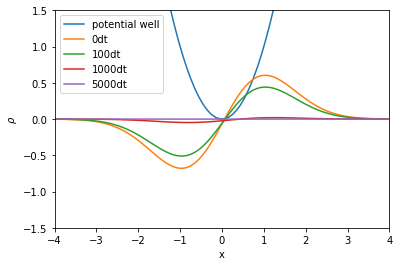

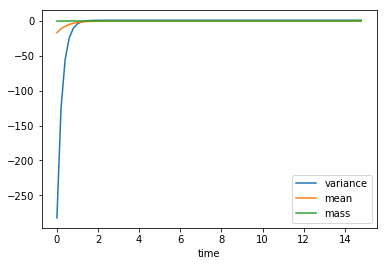

In [31]:

main = np.array(main)
plt.figure()
plt.plot(x[1:-1],pot[1:-1],label = 'potential well')
plt.plot(x[1:-1],main[0,1:-1],label = '0dt')
plt.plot(x[1:-1],main[100,1:-1],label = '100dt')
plt.plot(x[1:-1],main[1000,1:-1],label = '1000dt')
plt.plot(x[1:-1],main[5000,1:-1],label = '5000dt')
plt.ylim([-1.5,1.5])
plt.xlim([-4,4])
plt.ylabel(r'$\rho$')
plt.xlabel('x')
plt.legend()

mvar = np.array(mvar)
plt.figure()
plt.plot(tt,mvar[:,2],label = 'variance')
plt.plot(tt,mvar[:,1],label = 'mean')
plt.plot(tt,mvar[:,0],label = 'mass')
plt.legend()
plt.xlabel('time')




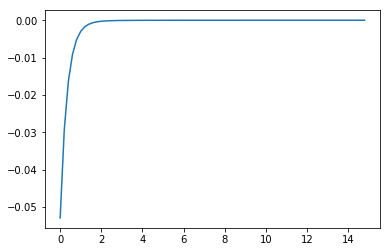

In [32]:
plt.plot(tt,ptracker)
tt = np.array(tt)
ptracker = np.array(ptracker)
a,b = np.polyfit(tt[0:5],np.log(-ptracker[0:5]),1)

In [35]:
print('the energy of first excited state is = %s' %-a)

the energy of first excited state is = 2.90899774789


If we carry out a log plot of the wavefunction in time for early time steps in the solver, we are actually able to extract the energy of the first excited state. If we take later times, we get back the energy of the ground state.

# Finite Volume

In [44]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
NX=nx=50
NV=49
x= np.zeros(NX+2)
xc=np.zeros(NV+2)
u=np.zeros(NX+2)
f=np.zeros(NV+2)
fnew=np.zeros(NV+2)

fmom = np.zeros(nm+1)
hmom = np.zeros(nm+1)
xmom = np.zeros(nm+1)
mvar = []
tt = []

NT   = 10001
nout = 500

dif = 1.0
vel = 0.1
sigma = NX/10
main = []

dx = 1.0
dt = 0.1
for j in range(1,NX+1):
    xj  = (j-1)*dx/float(NX-1)
    g   = (1.0-xj*xj)
    u[j] = vel*g
    x[j] = x[j-1]+dx*(0.5+u[j]/vel)   
for j in range(1,NV+1):
    xc[j] = 0.5*(x[j]+x[j+1])
    xj    = (x[j]-x[NX/2])/sigma
    f[j]  = np.exp(-0.5*xj*xj)

main.append(np.copy(f))
for it in range(1,NT):
    for j in range(2,NV):
        dxw = x[j]-x[j-1]
        dxc = x[j+1]-x[j]
        dxe = x[j+2]-x[j+1]
        ae = dxc/(dxc+dxe)
        aw = dxc/(dxc+dxw)

#c east/west surface values
        fw = f[j]*(1.0-aw)+aw*f[j-1]
        fe = f[j]*(1.0-ae)+ae*f[j+1]
#c velocity is node centered (edges)
        uw = u[j]
        ue = u[j+1]
        Aflux_e = -ue*fe
        Aflux_w = -uw*fw
# c diffusion
        Dflux_w = dif*(f[j]-f[j-1])/(xc[j]-xc[j-1])
        Dflux_e = dif*(f[j+1]-f[j])/(xc[j+1]-xc[j])

        flux_e  = Aflux_e + Dflux_e 
        flux_w  = Aflux_w + Dflux_w 

        fnew[j] = f[j] + (flux_e-flux_w)*dt/dxc

        
# c left boundary j=1
    dxc = x[2]-x[1]
    dxe = x[3]-x[2]
    ae = dxc/(dxc+dxe)
    fe = f[1]*(1-ae)+ae*f[2]
    ue = u[2]
    Aflux_e = -ue*fe
    Dflux_e = dif*(f[2]-f[1])/(xc[2]-xc[1])
#     c no flux from the west
    fnew[1] = f[1] + (Aflux_e+Dflux_e)*dt/dxc

#     c right  boundary j=nx-1
    dxc = x[nx]-x[nx-1]
    dxw = x[nx-1]-x[nx-2]
    aw = dxc/(dxc+dxw)
    fw = f[nx-1]*(1-aw)+aw*f[nx-2]
    uw = u[nx-1]
    Aflux_w = uw*fw
    Dflux_w = dif*(f[nx-1]-f[nx-2])/(xc[nx-1]-xc[nx-2])
#     c no flux from the east
    fnew[nx-1] = f[nx-1] -(Aflux_w+Dflux_w)*dt/dxc
#     c =========================================================
#     c new step
    for j in range(1,NV+1):
        f[j] = fnew[j]
    main.append(np.copy(f))
    
    if(np.mod(it,nout) ==1 ):
            for k in range(nm+1):
                fmom[k] = 0.0
                hmom[k] = 0.0
                xmom[k] = 0.0
            for k in range(nx):
                fj = f[k+1]
                fmom[0] = fmom[0] + fj*dx
                fmom[1] = fmom[1] + fj*x[k]*dx
                fmom[2] = fmom[2] + fj*x[k]*x[k]*dx

                hmom[2] = hmom[2] - fj*fj*dx
                hmom[3] = hmom[3] - (fj**3)*dx
                hmom[4] = hmom[4] - (fj**4)*dx
                if (x[k] > 0.9*sizex):
                    xmom[1] = xmom[1]+fj*x[k]
                    xmom[2] = xmom[2]+fj*x[k]**2
                    xmom[3] = xmom[3]+fj*x[k]**3
            fmean = fmom[1]/fmom[0]
            fvar = fmom[2]/fmom[0] - fmean*fmean
            mvar.append((fmean,fvar))
            tt.append(dt*it)


    

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


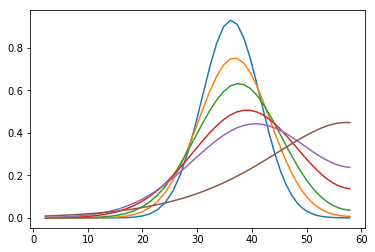

In [45]:
main = np.array(main)
plt.plot(xc[1:-1],main[20,1:-1])
plt.plot(xc[1:-1],main[100,1:-1])
plt.plot(xc[1:-1],main[200,1:-1])
plt.plot(xc[1:-1],main[400,1:-1])
plt.plot(xc[1:-1],main[600,1:-1])
plt.plot(xc[1:-1],main[8000,1:-1])

In [46]:
mvar = np.array(mvar)

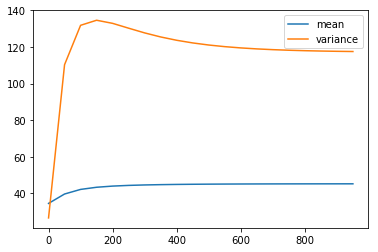

In [49]:
plt.plot(tt,mvar[:,0],label = 'mean')
plt.plot(tt,mvar[:,1],label = 'variance')
plt.legend()